# Imports

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import ta

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
from pprint import pprint

import gc
import optuna
from sklearn.feature_selection import RFE


/tmp/ipykernel_22425/384002432.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('Data/Training/pair_features_1_pairs1_300_120.csv')
df.head()

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls,actual_abs_spread,actual_abs_spread_std
0,EVRG,2001-02-09 00:00:00,24.790,24.260,204100.000,8.938,BKR,44.400,43.120,2349100.000,20.841,11.903,8.725,2.415,10.108,1.388,0.000,9.479,1.459
1,EVRG,2001-02-12 00:00:00,24.840,24.550,150400.000,8.866,BKR,44.010,42.800,3367600.000,20.547,11.681,8.748,2.410,10.137,1.402,0.000,9.435,1.432
2,EVRG,2001-02-13 00:00:00,25.020,24.600,369900.000,9.025,BKR,43.540,42.000,2061300.000,20.538,11.513,8.771,2.403,10.148,1.410,0.000,9.398,1.406
3,EVRG,2001-02-14 00:00:00,24.750,24.220,202900.000,8.826,BKR,43.950,42.100,2489000.000,20.126,11.300,8.797,2.390,10.151,1.413,0.000,9.361,1.384
4,EVRG,2001-02-15 00:00:00,24.490,23.850,226600.000,8.808,BKR,41.000,38.950,4808900.000,19.022,10.214,8.816,2.378,10.144,1.412,0.000,9.353,1.381


In [3]:
total_days = df.Date.nunique()
total_days

5698

In [4]:
df.pnls.describe()

count   5698.000
mean       0.001
std        0.043
min       -0.216
25%        0.000
50%        0.000
75%        0.010
max        0.195
Name: pnls, dtype: float64

### Beta

In [5]:
all_tickers = df['Ticker_P1'].unique().tolist()+df['Ticker_P2'].unique().tolist()
len(all_tickers)

2

### Single Ticker Features

In [6]:
df.columns

Index(['Ticker_P1', 'Date', 'High_P1', 'Low_P1', 'Volume_P1', 'Close_P1',
       'Ticker_P2', 'High_P2', 'Low_P2', 'Volume_P2', 'Close_P2', 'abs_spread',
       'abs_spread_mean', 'abs_spread_std', 'abs_spread_mean_MA',
       'abs_spread_std_MA', 'pnls', 'actual_abs_spread',
       'actual_abs_spread_std'],
      dtype='object')

In [7]:
df.sort_values('Date')

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls,actual_abs_spread,actual_abs_spread_std
0,EVRG,2001-02-09 00:00:00,24.790,24.260,204100.000,8.938,BKR,44.400,43.120,2349100.000,20.841,11.903,8.725,2.415,10.108,1.388,0.000,9.479,1.459
1,EVRG,2001-02-12 00:00:00,24.840,24.550,150400.000,8.866,BKR,44.010,42.800,3367600.000,20.547,11.681,8.748,2.410,10.137,1.402,0.000,9.435,1.432
2,EVRG,2001-02-13 00:00:00,25.020,24.600,369900.000,9.025,BKR,43.540,42.000,2061300.000,20.538,11.513,8.771,2.403,10.148,1.410,0.000,9.398,1.406
3,EVRG,2001-02-14 00:00:00,24.750,24.220,202900.000,8.826,BKR,43.950,42.100,2489000.000,20.126,11.300,8.797,2.390,10.151,1.413,0.000,9.361,1.384
4,EVRG,2001-02-15 00:00:00,24.490,23.850,226600.000,8.808,BKR,41.000,38.950,4808900.000,19.022,10.214,8.816,2.378,10.144,1.412,0.000,9.353,1.381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5693,EVRG,2023-09-28 00:00:00,51.370,50.210,2133100.000,49.778,BKR,36.850,36.200,5879800.000,36.121,13.657,29.852,6.549,20.739,3.341,0.000,16.055,2.058
5694,EVRG,2023-09-29 00:00:00,51.380,50.430,2605400.000,50.054,BKR,36.600,35.170,8093900.000,34.867,15.187,29.783,6.595,20.539,3.308,0.000,16.089,2.060
5695,EVRG,2023-10-02 00:00:00,51.450,47.690,4860400.000,47.487,BKR,35.350,34.090,6952700.000,34.117,13.370,29.703,6.648,20.349,3.386,0.000,16.160,2.038
5696,EVRG,2023-10-03 00:00:00,49.230,47.290,3100900.000,48.376,BKR,34.830,34.280,5839400.000,34.087,14.288,29.625,6.691,20.186,3.439,0.000,16.226,2.042


In [8]:
label = 'actual_abs_spread'
features_to_exclude = [] # ['High_P1', 'High_P2', 'Low_P1', 'Low_P2', 'abs_spread', 'abs_spread_mean', 'abs_spread_std']
always_exclude = ['pnls', 'actual_abs_spread_std']
X = df
y = df[label]

X = X.drop(['Date', 'Ticker_P1', 'Ticker_P2', 'Volume_P1', 'Volume_P2', label],axis=1)
X = X.drop(always_exclude, axis=1)
X = X.drop(features_to_exclude, axis=1)

In [9]:
X = X.dropna()
X['abs_spread_log_mean_MA'] = np.log(X['abs_spread_mean_MA'])
X['abs_spread_log_std_mean_MA'] = np.log(X['abs_spread_std_MA'])
X = X.drop(['abs_spread_mean_MA', 'abs_spread_std_MA'],axis=1)
X

,High_P1,Low_P1,Close_P1,High_P2,Low_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_log_mean_MA,abs_spread_log_std_mean_MA
0,24.790,24.260,8.938,44.400,43.120,20.841,11.903,8.725,2.415,2.313,0.328
1,24.840,24.550,8.866,44.010,42.800,20.547,11.681,8.748,2.410,2.316,0.338
2,25.020,24.600,9.025,43.540,42.000,20.538,11.513,8.771,2.403,2.317,0.344
3,24.750,24.220,8.826,43.950,42.100,20.126,11.300,8.797,2.390,2.318,0.346
4,24.490,23.850,8.808,41.000,38.950,19.022,10.214,8.816,2.378,2.317,0.345
...,...,...,...,...,...,...,...,...,...,...,...
5693,51.370,50.210,49.778,36.850,36.200,36.121,13.657,29.852,6.549,3.032,1.206
5694,51.380,50.430,50.054,36.600,35.170,34.867,15.187,29.783,6.595,3.022,1.196
5695,51.450,47.690,47.487,35.350,34.090,34.117,13.370,29.703,6.648,3.013,1.220
5696,49.230,47.290,48.376,34.830,34.280,34.087,14.288,29.625,6.691,3.005,1.235


In [10]:
y = np.log(y)
y.describe()

count   5698.000
mean       2.611
std        0.712
min        0.482
25%        2.187
50%        2.521
75%        3.291
max        3.719
Name: actual_abs_spread, dtype: float64

## Train test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=False)

In [12]:
print(df.loc[X_train.index].Date.min(),df.loc[X_train.index].Date.max())

2001-02-09 00:00:00 2019-03-26 00:00:00


In [13]:
print(df.loc[X_val.index].Date.min(),df.loc[X_val.index].Date.max())

2019-03-27 00:00:00 2021-06-29 00:00:00


In [14]:
print(df.loc[X_test.index].Date.min(),df.loc[X_test.index].Date.max())

2021-06-30 00:00:00 2023-10-04 00:00:00


## LSTM Model

In [15]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout
#Creating the LSTM model
class lstm(Model):
    def __init__(self, in_shape):
        super(lstm, self).__init__()
        self.shape = in_shape
        self.lstm = LSTM(512, input_shape=self.shape, dropout=0.2, return_sequences = True)
        self.dropout = Dropout(0.2)
        self.dense = Dense(1)

    def call(self, x):
        x = self.lstm(x)
#         x = self.dropout(x)
        x = self.dense(x)
        return x

2024-03-22 04:05:40.679844: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 04:05:41.422470: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [16]:
# Reshape X for model training
trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])).astype(np.float32)
valX = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1])).astype(np.float32)
testX = np.reshape(X_test, ( X_test.shape[0], 1, X_test.shape[1])).astype(np.float32)

In [17]:
trainX.shape

(4558, 1, 11)

In [18]:
#initializing the lstm model
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5,\
                                            min_delta=0.001,restore_best_weights=True,verbose=1)

lstm_model = lstm((trainX.shape[0], 1, trainX.shape[1]))
lstm_model.compile(loss='mae', 
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.00002), metrics=['mae'])
#fitting the model
history = lstm_model.fit(
                    trainX, 
                    y_train,
                    validation_data=(valX, y_val), 
                    epochs=50, 
                    batch_size=32,
                    verbose=1, 
                    callbacks=callback,
                    shuffle=False)       

Epoch 1/50


2024-03-22 04:05:42.253500: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


143/143 [==============================] - 3s 14ms/step - loss: 1.5483 - mae: 1.5483 - val_loss: 1.1129 - val_mae: 1.1129
Epoch 2/50
143/143 [==============================] - 2s 11ms/step - loss: 0.6869 - mae: 0.6869 - val_loss: 0.5994 - val_mae: 0.5994
Epoch 3/50
143/143 [==============================] - 2s 12ms/step - loss: 0.5266 - mae: 0.5266 - val_loss: 0.3899 - val_mae: 0.3899
Epoch 4/50
143/143 [==============================] - 2s 11ms/step - loss: 0.4510 - mae: 0.4510 - val_loss: 0.2813 - val_mae: 0.2813
Epoch 5/50
143/143 [==============================] - 2s 11ms/step - loss: 0.4205 - mae: 0.4205 - val_loss: 0.2517 - val_mae: 0.2517
Epoch 6/50
143/143 [==============================] - 2s 11ms/step - loss: 0.3939 - mae: 0.3939 - val_loss: 0.2422 - val_mae: 0.2422
Epoch 7/50
143/143 [==============================] - 2s 11ms/step - loss: 0.3746 - mae: 0.3746 - val_loss: 0.2530 - val_mae: 0.2530
Epoch 8/50
143/143 [==============================] - 2s 11ms/step - loss: 0.359

In [19]:
lstm_model.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               multiple                  1073152   
                                                                 
 dropout (Dropout)           multiple                  0 (unused)
                                                                 
 dense (Dense)               multiple                  513       
                                                                 
Total params: 1073665 (4.10 MB)
Trainable params: 1073665 (4.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


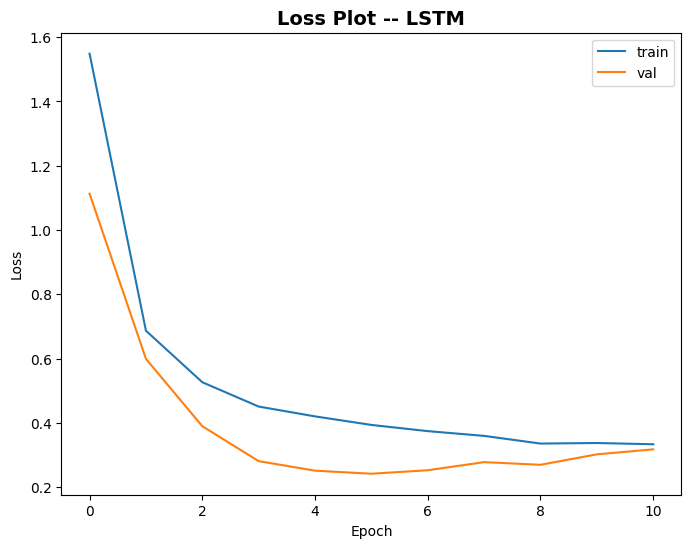

In [20]:
# Plot line graph to show amount loss according the the epoch
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss Plot -- LSTM', fontsize=14, color="black", fontweight="bold")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
inference_result = lstm_model.predict(testX).flatten()

18/18 [==============================] - 0s 2ms/step


count   570.000
mean      3.396
std       0.241
min       2.737
25%       3.371
50%       3.421
75%       3.577
max       3.685
Name: actual_abs_spread, dtype: float64

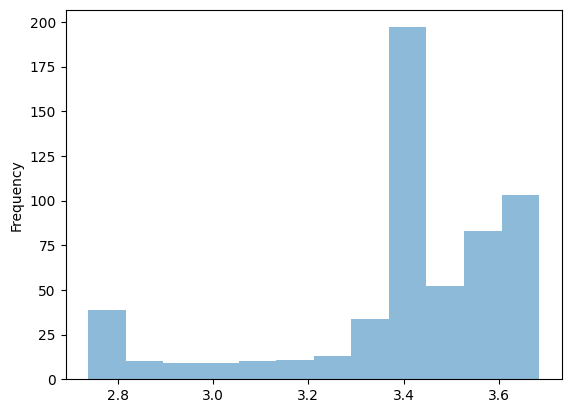

In [22]:
y_test.plot.hist(bins=12, alpha=0.5)
y_test.describe()

count   570.000
mean      3.330
std       0.104
min       2.907
25%       3.286
50%       3.345
75%       3.394
max       3.511
dtype: float64

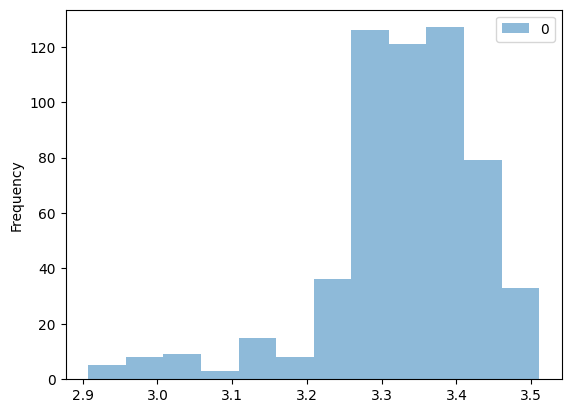

In [23]:
pd.DataFrame(inference_result).plot.hist(bins=12, alpha=0.5)
pd.Series(inference_result).describe()

In [24]:
lstm_mae = (inference_result[:len(y_test)] - y_test).abs().mean()
lstm_mae

0.15039297740412344

In [25]:
inference_result

array([3.3306797, 3.3393857, 3.346575 , 3.3626459, 3.3578894, 3.35308  ,
       3.351094 , 3.3560622, 3.353089 , 3.369314 , 3.3751905, 3.3912737,
       3.3765972, 3.3765337, 3.3827176, 3.3795083, 3.3879337, 3.3963487,
       3.4036431, 3.399594 , 3.408177 , 3.4076784, 3.4181993, 3.4142673,
       3.4158924, 3.420055 , 3.4242299, 3.4216642, 3.426472 , 3.4320767,
       3.4361262, 3.442169 , 3.4457686, 3.4539154, 3.4555767, 3.4444544,
       3.4424553, 3.4541981, 3.4534376, 3.4592566, 3.4646175, 3.4571147,
       3.456206 , 3.4567924, 3.460212 , 3.4663062, 3.462457 , 3.4420817,
       3.4540868, 3.4577377, 3.4316304, 3.4301689, 3.4164546, 3.3963532,
       3.405937 , 3.3938508, 3.3944213, 3.3905735, 3.3741515, 3.3790073,
       3.3728237, 3.3665173, 3.3674462, 3.369208 , 3.353512 , 3.3447654,
       3.3569367, 3.3705342, 3.3786945, 3.368182 , 3.3519166, 3.3512695,
       3.3507757, 3.352943 , 3.3624895, 3.3646038, 3.3535945, 3.3664978,
       3.4069288, 3.4094183, 3.4028962, 3.3922656, 

In [26]:
mae = lstm_mae / y_test.abs().mean()
mae

0.044291537216131834

In [27]:
# Generate the PNL from predicted spread
from pair_trading_foundations.data_generation import ExecutePairTrading

BacktestData = df.loc[X_test.index]

samples = BacktestData
samples = samples.drop(['Date', 'Ticker_P1', 'Ticker_P2', 'Volume_P1', 'Volume_P2', label],axis=1)
samples = samples.drop(always_exclude,axis=1)
samples = samples.drop(features_to_exclude,axis=1)
samples['abs_spread_log_mean_MA'] = np.log(samples.abs_spread_mean_MA)
samples['abs_spread_log_std_mean_MA'] = np.log(samples.abs_spread_std_MA)
samples = samples.drop(['abs_spread_mean_MA', 'abs_spread_std_MA'],axis=1)


model_input = np.reshape(samples, (samples.shape[0], 1, samples.shape[1])).astype(np.float32)
inference_result = lstm_model.predict(model_input).flatten()
BacktestData['pred_abs_spread'] = np.exp(inference_result)
BacktestData['z_score'] = (np.log(BacktestData['pred_abs_spread']) / BacktestData['abs_spread_std_MA'])
BacktestData = BacktestData.reset_index(drop=True)
BacktestData = BacktestData.drop(['actual_abs_spread', 'actual_abs_spread_std'], axis=1)
BacktestData 

18/18 [==============================] - 0s 2ms/step


,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls,pred_abs_spread,z_score
0,EVRG,2021-06-30 00:00:00,60.790,60.110,797800.000,54.827,BKR,23.140,22.650,5793900.000,21.257,33.569,33.745,4.282,35.152,2.294,0.136,27.957,1.452
1,EVRG,2021-07-01 00:00:00,61.730,60.460,669700.000,55.698,BKR,23.760,23.300,7101700.000,21.880,33.818,33.731,4.275,35.127,2.300,0.136,28.202,1.452
2,EVRG,2021-07-02 00:00:00,61.720,61.120,519900.000,55.870,BKR,23.630,22.980,8048600.000,21.889,33.981,33.715,4.265,35.099,2.304,0.136,28.405,1.453
3,EVRG,2021-07-06 00:00:00,61.790,60.790,878800.000,55.988,BKR,23.530,22.310,11507900.000,20.830,35.158,33.701,4.253,35.085,2.301,0.136,28.865,1.462
4,EVRG,2021-07-07 00:00:00,61.890,61.080,895000.000,56.088,BKR,22.720,21.890,6672500.000,20.690,35.398,33.687,4.241,35.070,2.296,0.136,28.728,1.463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,EVRG,2023-09-28 00:00:00,51.370,50.210,2133100.000,49.778,BKR,36.850,36.200,5879800.000,36.121,13.657,29.852,6.549,20.739,3.341,0.000,18.308,0.870
566,EVRG,2023-09-29 00:00:00,51.380,50.430,2605400.000,50.054,BKR,36.600,35.170,8093900.000,34.867,15.187,29.783,6.595,20.539,3.308,0.000,19.208,0.893
567,EVRG,2023-10-02 00:00:00,51.450,47.690,4860400.000,47.487,BKR,35.350,34.090,6952700.000,34.117,13.370,29.703,6.648,20.349,3.386,0.000,18.713,0.865
568,EVRG,2023-10-03 00:00:00,49.230,47.290,3100900.000,48.376,BKR,34.830,34.280,5839400.000,34.087,14.288,29.625,6.691,20.186,3.439,0.000,18.747,0.852


In [28]:
pnls = []
entry_signal = 2    # Make sure this matches with data pipeline
exit_signal = 0.5   # Make sure this matches with data pipeline
test_len = 60       # Make sure this matches with data pipeline
for idx in range(BacktestData.shape[0]):
    if (idx > BacktestData.shape[0]-test_len-1):
        pnls.append(np.nan)
    else:
        current_row = BacktestData.loc[idx]
        result = ExecutePairTrading(current_row.pred_abs_spread,   # Use predicted spread
                                    current_row.abs_spread_std_MA, # Use current std deviation
                                    entry_signal=entry_signal,
                                    exit_signal=exit_signal
                                ).execute(
                                    # Forward window
                                    vec1=BacktestData.loc[(idx+1):(idx+test_len)]['Close_P1'].values,
                                    vec2=BacktestData.loc[(idx+1):(idx+test_len)]['Close_P2'].values,
                                    dates=BacktestData.loc[(idx+1):(idx+test_len)]['Date'].values,
                                    base_fund=100,
                                )

        pnls.append(result.final_pl_pct)

BacktestData['pred_pnls'] = pnls
BacktestData = BacktestData.dropna()

strategy = BacktestData.loc[(abs(BacktestData['z_score']) > 0.95) & (BacktestData['pred_pnls'] > 0)]
strategy

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls,pred_abs_spread,z_score,pred_pnls
0,EVRG,2021-06-30 00:00:00,60.790,60.110,797800.000,54.827,BKR,23.140,22.650,5793900.000,21.257,33.569,33.745,4.282,35.152,2.294,0.136,27.957,1.452,0.000
1,EVRG,2021-07-01 00:00:00,61.730,60.460,669700.000,55.698,BKR,23.760,23.300,7101700.000,21.880,33.818,33.731,4.275,35.127,2.300,0.136,28.202,1.452,0.017
2,EVRG,2021-07-02 00:00:00,61.720,61.120,519900.000,55.870,BKR,23.630,22.980,8048600.000,21.889,33.981,33.715,4.265,35.099,2.304,0.136,28.405,1.453,0.050
3,EVRG,2021-07-06 00:00:00,61.790,60.790,878800.000,55.988,BKR,23.530,22.310,11507900.000,20.830,35.158,33.701,4.253,35.085,2.301,0.136,28.865,1.462,0.053
4,EVRG,2021-07-07 00:00:00,61.890,61.080,895000.000,56.088,BKR,22.720,21.890,6672500.000,20.690,35.398,33.687,4.241,35.070,2.296,0.136,28.728,1.463,0.061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,EVRG,2023-04-24 00:00:00,63.290,62.560,676800.000,60.985,BKR,30.420,29.560,5856300.000,29.434,31.551,31.915,4.690,29.213,2.241,0.036,28.758,1.499,0.044
458,EVRG,2023-04-26 00:00:00,63.650,62.000,921000.000,59.960,BKR,29.480,28.510,5742100.000,28.040,31.920,31.931,4.688,29.334,2.317,0.000,28.794,1.450,0.044
459,EVRG,2023-04-27 00:00:00,62.730,61.850,932700.000,60.444,BKR,29.030,28.400,6118600.000,28.118,32.326,31.942,4.686,29.387,2.349,0.000,29.050,1.434,0.036
460,EVRG,2023-04-28 00:00:00,62.810,61.700,970800.000,60.038,BKR,29.380,28.520,5412600.000,28.508,31.530,31.953,4.681,29.426,2.365,0.000,28.640,1.418,0.044


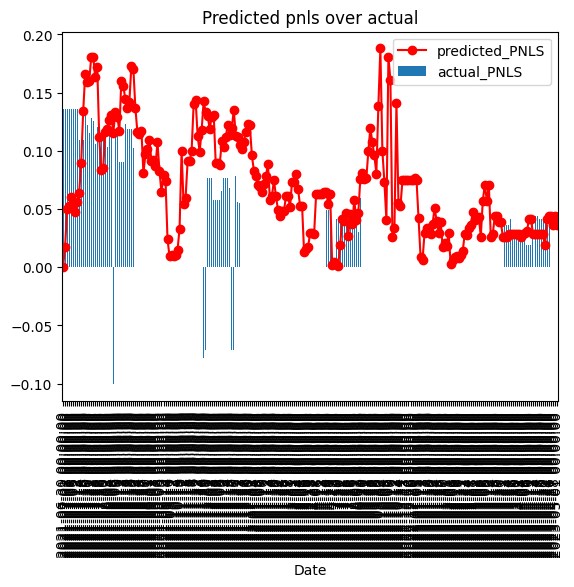

<Figure size 800x600 with 0 Axes>

In [29]:
if len(strategy):
    pnl_filters = strategy.filter(items=['Date', 'pnls', 'pred_pnls'])
    pnl_filters = pnl_filters.rename(columns={'pnls': 'actual_PNLS', 'pred_pnls': 'predicted_PNLS'})
    ax = pnl_filters.plot(x='Date',y=['predicted_PNLS'],  linestyle='-', marker='o', color='red')
    pnl_filters.plot(x='Date',y=['actual_PNLS'], kind='bar', ax=ax)
    ax.set_title('Predicted pnls over actual')
    plt.figure(figsize=(8,6))
    plt.show()
else:
    print('No valid entry available')

In [30]:
# Strategy 1: Execute each recommended trade by X amount
if len(strategy):
    average_pnl = pnl_filters.actual_PNLS.sum() / len(pnl_filters.actual_PNLS)
    print('Returns: ', average_pnl)

Returns:  0.02534523659554171


In [31]:
# Strategy 2: Execute top 10 recommended trade by X amount
if len(strategy):
    best_num = 10
    pnl_filters = pnl_filters.reset_index(drop=True)
    # Get the top 10 predictions for PNL
    sorted_indices = pnl_filters.predicted_PNLS.argsort()[::-1]
    top_k = sorted_indices[sorted_indices < best_num]

    # Retrieve the actual PNL
    average_pnl = pnl_filters.actual_PNLS[top_k].sum() / best_num
    print('Returns: ', average_pnl)

Returns:  0.13049927719666463


In [32]:
# Normality test

from scipy.stats import shapiro
# normality test
stat, p = shapiro(inference_result)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.901, p=0.000
Sample does not look Gaussian (reject H0)


In [33]:
# D’Agostino’s K^2 Test
from scipy.stats import normaltest
# normality test
stat, p = normaltest(inference_result)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=153.750, p=0.000
Sample does not look Gaussian (reject H0)


In [34]:
# Anderson-Darling Test
from scipy.stats import anderson
result = anderson(inference_result)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
if result.statistic < result.critical_values[i]:
    print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
else:
    print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 11.865
1.000: 1.084, data does not look normal (reject H0)
